In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import DatasetDict, Dataset, load_dataset
import evaluate
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

/Users/ashu/anaconda3/envs/image_fl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# d1 = load_dataset('imagefolder', data_dir='./Shoe vs Sandal vs Boot Dataset/')
datasets = load_dataset('imagefolder', data_dir='./Thermography-image-data/')

Resolving data files: 100%|██████████| 5583/5583 [00:00<00:00, 63874.39it/s]


In [3]:
datasets_split = datasets['train'].train_test_split(test_size=.4, seed=42)
datasets['train'] = datasets_split['train']
datasets['test'] = datasets_split['test']

In [4]:
datasets_validation_train_ = datasets['train'].train_test_split(test_size=.4)
datasets['train'] = datasets_validation_train_['train']
datasets['validation'] = datasets_validation_train_['test']

In [5]:
datasets['train'].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['Healthy', 'Sick'], id=None)}

In [6]:
labels = datasets['train'].features['label'].names

In [7]:
labels

['Healthy', 'Sick']

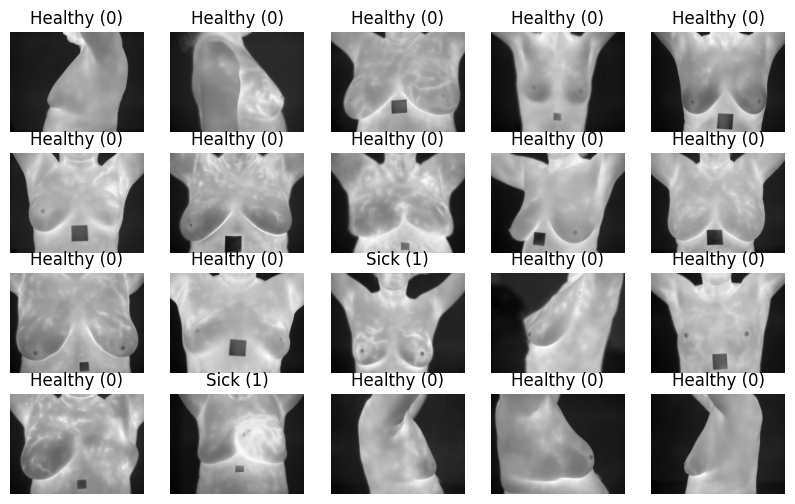

In [8]:
# plot samples
samples = datasets['train'].select(range(20))
pointer = 0
fig, ax = plt.subplots(4,5, sharex=True, sharey=True, figsize=(10,6))
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1
plt.show()

In [9]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)
print(extractor(samples[0]['image'], return_tensors='pt'))

{'pixel_values': tensor([[[[-0.8745, -0.8667, -0.8824,  ..., -0.8431, -0.8431, -0.8588],
          [-0.8588, -0.8667, -0.8745,  ..., -0.8353, -0.8353, -0.8510],
          [-0.8510, -0.8667, -0.8667,  ..., -0.8275, -0.8353, -0.8510],
          ...,
          [-0.9608, -0.9765, -0.9686,  ..., -0.8745, -0.8745, -0.8902],
          [-0.9608, -0.9765, -0.9686,  ..., -0.8824, -0.8745, -0.8902],
          [-0.9608, -0.9765, -0.9686,  ..., -0.8902, -0.8824, -0.8980]],

         [[-0.8745, -0.8667, -0.8824,  ..., -0.8431, -0.8431, -0.8588],
          [-0.8588, -0.8667, -0.8745,  ..., -0.8353, -0.8353, -0.8510],
          [-0.8510, -0.8667, -0.8667,  ..., -0.8275, -0.8353, -0.8510],
          ...,
          [-0.9608, -0.9765, -0.9686,  ..., -0.8745, -0.8745, -0.8902],
          [-0.9608, -0.9765, -0.9686,  ..., -0.8824, -0.8745, -0.8902],
          [-0.9608, -0.9765, -0.9686,  ..., -0.8902, -0.8824, -0.8980]],

         [[-0.8745, -0.8667, -0.8824,  ..., -0.8431, -0.8431, -0.8588],
          [-0

/Users/ashu/anaconda3/envs/image_fl/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
tensor = extractor(samples[0]['image'],return_tensors='pt')['pixel_values']
tensor.shape

torch.Size([1, 3, 224, 224])

In [11]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs
transformed_data = datasets.with_transform(batch_transform)

In [12]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

In [13]:
# metrics
metric = evaluate.load('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }

In [14]:
model = ViTForImageClassification.from_pretrained(
    model_ckpt,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
zero_loader = DataLoader(transformed_data['test'], batch_size=32)
zero_pred = []

for batch in tqdm(zero_loader):
	with torch.no_grad():        
		logits = model(batch['pixel_values'].to(device)).logits
		pred = logits.argmax(-1).cpu().detach().tolist()
		zero_pred += [labels[i] for i in pred]


100%|██████████| 70/70 [00:50<00:00,  1.39it/s]


In [16]:
zero_true = [labels[i] for i in datasets['test']['label']]

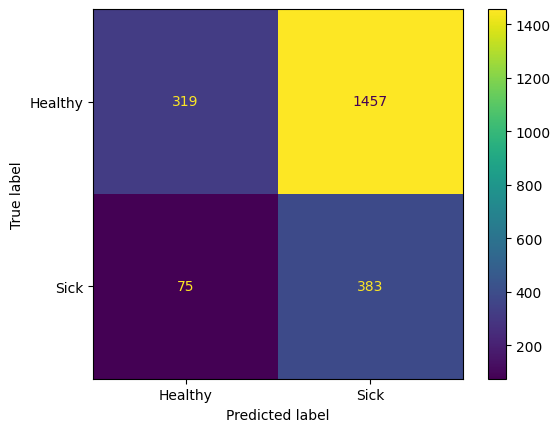

Acc: 0.314
F1: 0.302


In [17]:
# plot confusion matrix
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()
# metrics
print(f'Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

In [20]:
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

training_args = TrainingArguments(
    output_dir='./output/',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    use_mps_device=True,
    # fp16=True if torch.cuda.is_available else False,
    logging_steps=logging_steps,
    learning_rate=1e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=transformed_data['train'],
    eval_dataset=transformed_data['validation'],
    tokenizer=extractor)

trainer.train()

100%|██████████| 378/378 [16:11<00:00,  2.57s/it]
                                                 

 33%|███▎      | 125/378 [02:08<04:13,  1.00s/it]


{'loss': 0.0963, 'learning_rate': 6.693121693121693e-06, 'epoch': 0.99}


 33%|███▎      | 126/378 [02:09<03:42,  1.13it/s]
                                                 

 33%|███▎      | 126/378 [02:41<03:42,  1.13it/s]
Checkpoint destination directory ./output/checkpoint-126 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.19239237904548645, 'eval_accuracy': 0.9388059701492537, 'eval_f1': 0.9355736295802203, 'eval_runtime': 32.2164, 'eval_samples_per_second': 41.594, 'eval_steps_per_second': 2.607, 'epoch': 1.0}


                                                 

 66%|██████▌   | 250/378 [04:52<02:09,  1.01s/it]


{'loss': 0.0501, 'learning_rate': 3.3862433862433864e-06, 'epoch': 1.98}


 67%|██████▋   | 252/378 [04:53<01:50,  1.14it/s]
                                                 

 67%|██████▋   | 252/378 [05:25<01:50,  1.14it/s]
Checkpoint destination directory ./output/checkpoint-252 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.12492833286523819, 'eval_accuracy': 0.9649253731343284, 'eval_f1': 0.9647456466281016, 'eval_runtime': 32.1775, 'eval_samples_per_second': 41.644, 'eval_steps_per_second': 2.611, 'epoch': 2.0}


                                                 

 99%|█████████▉| 375/378 [07:34<00:03,  1.01s/it]


{'loss': 0.0232, 'learning_rate': 7.936507936507937e-08, 'epoch': 2.98}


100%|██████████| 378/378 [07:36<00:00,  1.11it/s]
                                                 

100%|██████████| 378/378 [08:08<00:00,  1.11it/s]


{'eval_loss': 0.13009949028491974, 'eval_accuracy': 0.9597014925373134, 'eval_f1': 0.9600380372978132, 'eval_runtime': 31.7866, 'eval_samples_per_second': 42.156, 'eval_steps_per_second': 2.643, 'epoch': 3.0}


                                                 

100%|██████████| 378/378 [08:11<00:00,  1.30s/it]

{'train_runtime': 491.6964, 'train_samples_per_second': 12.258, 'train_steps_per_second': 0.769, 'train_loss': 0.05632678687414795, 'epoch': 3.0}


TrainOutput(global_step=378, training_loss=0.05632678687414795, metrics={'train_runtime': 491.6964, 'train_samples_per_second': 12.258, 'train_steps_per_second': 0.769, 'train_loss': 0.05632678687414795, 'epoch': 3.0})

In [22]:
# inference on test data
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

100%|██████████| 140/140 [00:53<00:00,  2.61it/s]


{'test_loss': 0.11254895478487015,
 'test_accuracy': 0.9677708146821844,
 'test_f1': 0.9675565957822645,
 'test_runtime': 56.1308,
 'test_samples_per_second': 39.8,
 'test_steps_per_second': 2.494}

In [23]:
predictions

PredictionOutput(predictions=array([[ 2.0611992, -2.4909413],
       [ 2.0839393, -2.4759865],
       [ 2.0960371, -2.4782536],
       ...,
       [ 1.9989941, -2.434194 ],
       [-1.4094938,  1.6976409],
       [ 1.891228 , -2.2112005]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 1, 0]), metrics={'test_loss': 0.11254895478487015, 'test_accuracy': 0.9677708146821844, 'test_f1': 0.9675565957822645, 'test_runtime': 56.1308, 'test_samples_per_second': 39.8, 'test_steps_per_second': 2.494})

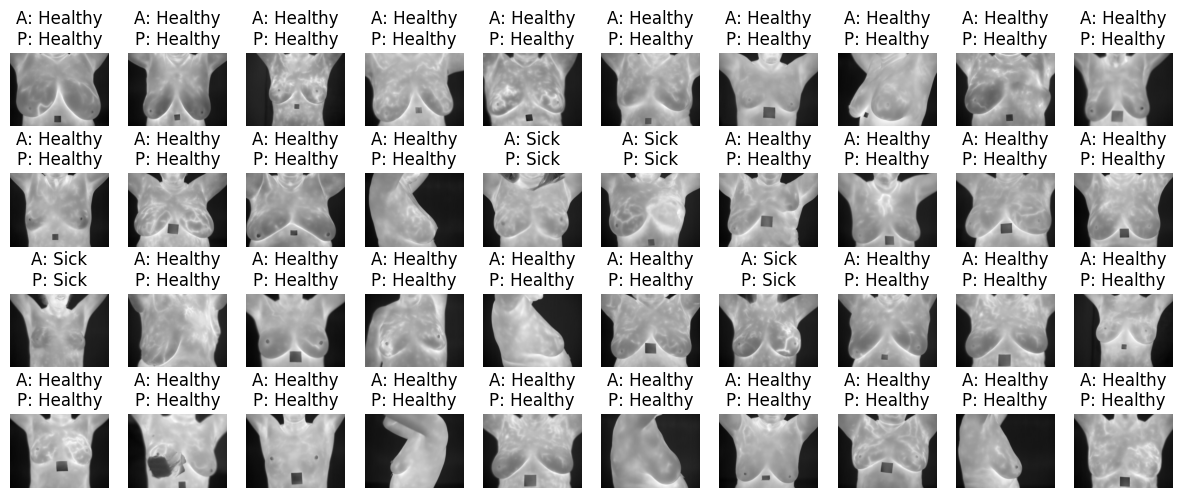

In [25]:
# plot samples
samples = datasets['test'].select(range(40))
pointer = 0
fig, ax = plt.subplots(4, 10, sharex=True, sharey=True, figsize=(15,6))
zero_pred = []
zero_true = []
for i in range(4):
    for j in range(10):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1
plt.show()


100%|██████████| 70/70 [00:51<00:00,  1.37it/s]


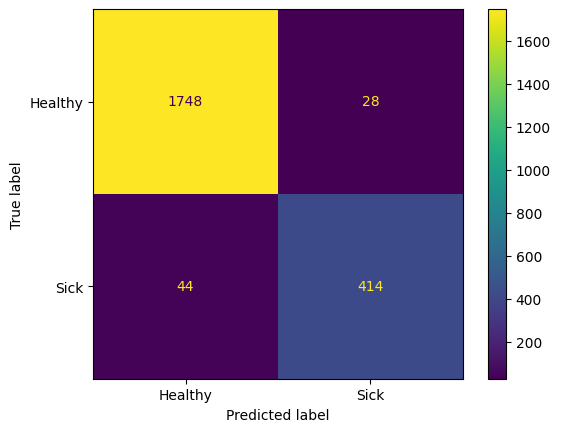

Acc: 0.968
F1: 0.968


In [21]:
zero_loader = DataLoader(transformed_data['test'], batch_size=32)
zero_pred = []

for batch in tqdm(zero_loader):
	with torch.no_grad():        
		logits = model(batch['pixel_values'].to(device)).logits
		pred = logits.argmax(-1).cpu().detach().tolist()
		zero_pred += [labels[i] for i in pred]

zero_true = [labels[i] for i in datasets['test']['label']]
# plot confusion matrix
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()
# metrics
print(f'Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')